In [1]:
# Import necessary libraries
from google.colab import drive
import os

# --- Step 1: Mount Google Drive ---
# This will prompt you for authorization to access your Google Drive files.
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully!")


# --- IMPORTANT: SPECIFY THE PATH TO YOUR ZIP FILE ---
# Replace this with the correct path to your dataset's ZIP file on Google Drive.
# To get the path, go to the file in your Drive, click the three dots, and select "Copy path".
zip_file_path = '/content/drive/MyDrive/ML Project/archive.zip' # <-- CHANGE THIS
# ----------------------------------------------------


# --- IMPORTANT: SPECIFY DIRECTORY NAMES ---
# Define a name for the directory where the dataset will be unzipped.
unzip_dir = "./plant_disease_dataset" # <-- You can change this if you like
# -------------------------------------------


# Check if the zip file exists before proceeding
if not os.path.exists(zip_file_path):
    print(f"ERROR: The file was not found at the specified path: {zip_file_path}")
    print("Please make sure the path is correct and the file is in your Google Drive.")
else:
    # Unzip the file from Google Drive to your Colab environment
    # The '-q' flag is for quiet mode to avoid verbose output
    print(f"\nUnzipping {zip_file_path}...")
    !unzip -q "{zip_file_path}" -d {unzip_dir}
    print("File unzipped successfully!")

    # --- IMPORTANT: DEFINE THE PATH TO YOUR IMAGE FOLDER ---
    # After unzipping, you need to find the exact path to your images.
    # The structure might be different depending on how the ZIP file was created.
    # Update this path based on the actual folder structure inside the 'unzip_dir'.
    data_dir = f'{unzip_dir}/PlantVillage' # <-- CHANGE THIS if your image folder has a different name

    print(f"\nThe image data should be located in: {data_dir}")

    # A helper command to list the contents of your unzipped directory.
    # This will help you find the correct folder name for 'data_dir'.
    print(f"\nContents of the unzipped directory ({unzip_dir}):")
    !ls {unzip_dir}

    # A final check to see if the data_dir exists
    if os.path.isdir(data_dir):
        print(f"\nSuccessfully located the image directory at: {data_dir}")
    else:
        print(f"\nWARNING: Could not find the directory '{data_dir}'.")
        print("Please check the folder contents listed above and correct the 'data_dir' variable.")




Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!

Unzipping /content/drive/MyDrive/ML Project/archive.zip...
File unzipped successfully!

The image data should be located in: ./plant_disease_dataset/PlantVillage

Contents of the unzipped directory (./plant_disease_dataset):
plantvillage  PlantVillage

Successfully located the image directory at: ./plant_disease_dataset/PlantVillage


Creating the training dataset...
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Creating the validation dataset...
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.

Found 15 classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

Displaying a sample of images from the training dataset...


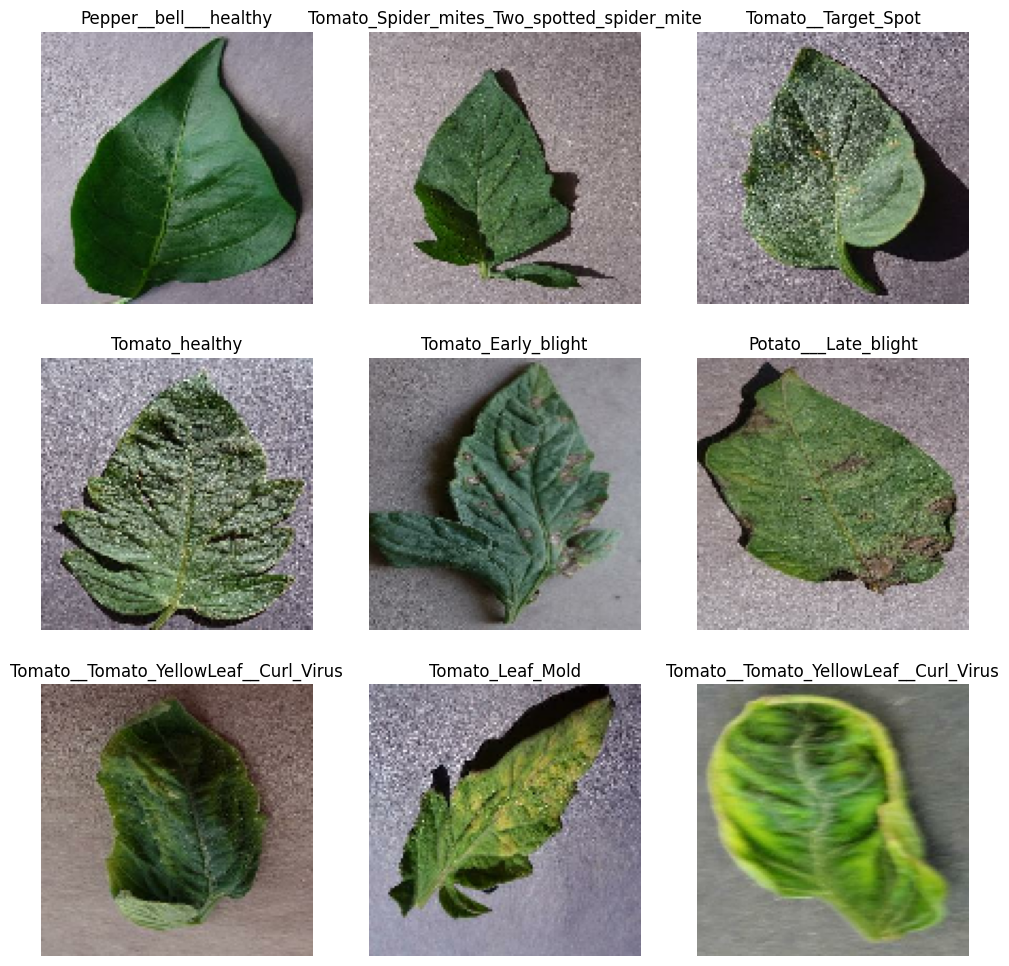


Datasets are now configured for optimal performance.


In [2]:
# Import necessary libraries for data handling and visualization
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define Constants and Parameters ---

# The directory where the image data is located, from Step 1
# This should be './plant_disease_dataset/PlantVillage' based on your output
data_dir = './plant_disease_dataset/PlantVillage'

# Set the dimensions for the images. All images will be resized to this.
IMG_HEIGHT = 128
IMG_WIDTH = 128
# Set the batch size for training. This is the number of images processed in one go.
BATCH_SIZE = 32


# --- 2. Load and Split the Dataset ---

# Create the training dataset from the image directory.
# We'll use 80% of the data for training.
# The 'image_dataset_from_directory' utility automatically infers labels from folder names.
print("Creating the training dataset...")
train_dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',     # Specify this is the training subset
)

# Create the validation dataset from the same directory.
# We'll use the remaining 20% of the data for validation.
print("Creating the validation dataset...")
validation_dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2, # Use the same split percentage
    subset='validation',  # Specify this is the validation subset
)

# Get the class names from the dataset. These correspond to the folder names.
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"\nFound {num_classes} classes: {class_names}")


# --- 3. Visualize the Data ---

# Let's look at a few images from a batch in the training dataset to verify.
print("\nDisplaying a sample of images from the training dataset...")
plt.figure(figsize=(12, 12))
# Take one batch from the training dataset
for images, labels in train_dataset.take(1):
    # Plot the first 9 images from that batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Find the index of the '1' in the one-hot encoded label to get the class name
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")
plt.show()


# --- 4. Configure Dataset for Performance ---

# Use buffered prefetching to load data in the background while the model is training.
# This improves performance by preventing I/O bottlenecks.
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\nDatasets are now configured for optimal performance.")


In [3]:
# Import necessary TensorFlow components
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np

# --- 1. Load and Prepare Datasets with Higher Resolution ---

# Define data directory and image parameters
data_dir = './plant_disease_dataset/PlantVillage'
# INCREASED IMAGE SIZE: Larger images provide more detail for the model to learn from.
# 224x224 is a common size for more advanced models.
IMG_HEIGHT = 224
IMG_WIDTH = 224
# INCREASED BATCH SIZE: A T4 GPU can handle larger batches, which can speed up training.
BATCH_SIZE = 64

# Create the training dataset from the image directory.
print("Creating the training dataset...")
train_dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
)

# Create the validation dataset from the same directory.
print("Creating the validation dataset...")
validation_dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
)

# Get the class names for the model's output layer
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"\nFound {num_classes} classes.")

# Configure datasets for optimal performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Datasets configured for performance.")


# --- 2. Create a More Advanced Data Augmentation Layer ---

print("\nSetting up data augmentation...")
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3), # Increased rotation range
        layers.RandomZoom(0.3),   # Increased zoom range
        layers.RandomContrast(0.2), # Added contrast adjustment
    ],
    name="data_augmentation",
)


# --- 3. Build a Deeper, More Powerful CNN Model ---

print("Building the enhanced CNN model...")

model = models.Sequential([
    # Input Layer
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Rescaling Layer
    layers.Rescaling(1./255),

    # Data Augmentation
    data_augmentation,

    # --- Feature Extraction Block (Deeper Architecture) ---

    # Block 1
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(), # ADDED: Stabilizes training and can speed it up.
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(), # ADDED
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(), # ADDED
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # ADDED DEEPER BLOCK: Allows the model to learn even more complex features.
    # Block 4
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(), # ADDED
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # --- Classification Head ---
    layers.Flatten(),
    # INCREASED DENSE LAYER SIZE: Gives the model more capacity to learn from the complex features.
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(), # ADDED
    layers.Dropout(0.5), # Helps prevent overfitting in this larger model.
    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])


# --- 4. Compile the Model ---

print("Compiling the model...")
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# --- 5. Display Model Architecture ---

print("\nModel Summary:")
model.summary()


# --- 6. Train the Model ---

print("\nStarting model training...")
# INCREASED EPOCHS: With a more complex model and more data, we can train for longer.
EPOCHS = 20

# The `fit` method trains the model.
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

print("\nModel training finished!")


Creating the training dataset...
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Creating the validation dataset...
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.

Found 15 classes.
Datasets configured for performance.

Setting up data augmentation...
Building the enhanced CNN model...
Compiling the model...

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,090,703 (99.53 MB)

 Trainable params: 26,088,719 (99.52 MB)

 Non-trainable params: 1,984 (7.75 KB)


Starting model training...
Epoch 1/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 89s 303ms/step - accuracy: 0.5592 - loss: 1.4615 - val_accuracy: 0.1432 - val_loss: 6.0096
Epoch 2/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms/step - accuracy: 0.7926 - loss: 0.6369 - val_accuracy: 0.5997 - val_loss: 1.6984
Epoch 3/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms/step - accuracy: 0.8408 - loss: 0.4900 - val_accuracy: 0.5411 - val_loss: 2.8925
Epoch 4/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms/step - accuracy: 0.8747 - loss: 0.3828 - val_accuracy: 0.5309 - val_loss: 2.9207
Epoch 5/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms/step - accuracy: 0.8888 - loss: 0.3339 - val_accuracy: 0.5338 - val_loss: 3.7496
Epoch 6/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms/step - accuracy: 0.9003 - loss: 0.2985 - val_accuracy: 0.8158 - val_loss: 0.5961
Epoch 7/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms/step - accuracy: 0.9133 - loss: 0.2554 - val_accuracy: 0.6918 - val_loss: 1.3863
Epoch 8/20
258/258 ━━━━━━━━━━━━━━━━━━━━ 71s 274ms/step 

Visualizing model performance over training epochs...


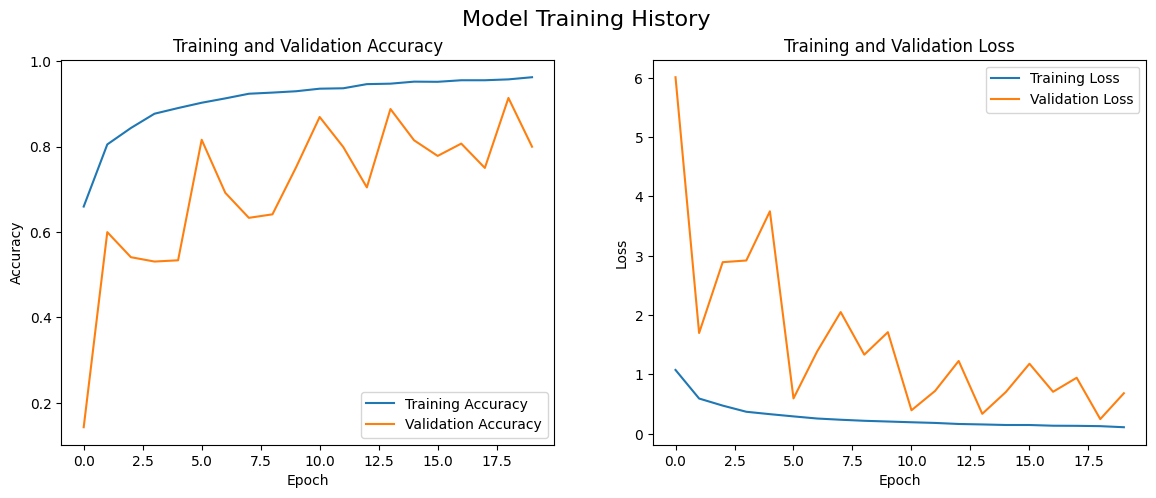


Evaluating the model on the validation dataset...
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8008 - loss: 0.6903
--------------------------------------------------
Final Validation Loss: 0.6832
Final Validation Accuracy: 0.7996 (79.96%)
--------------------------------------------------


In [4]:
import matplotlib.pyplot as plt

# --- 1. Visualize Training History ---

# The 'history' object was returned by the model.fit() method and contains
# the accuracy and loss values for both the training and validation sets at each epoch.

print("Visualizing model performance over training epochs...")

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs the model was trained for
epochs_range = range(len(acc))

# Create a figure to hold our plots
plt.figure(figsize=(14, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plots
plt.suptitle('Model Training History', fontsize=16)
plt.show()


# --- 2. Evaluate the Model on the Validation Dataset ---

# Now, let's get a final, precise measure of the model's performance
# by evaluating it on the validation data it has never used for training adjustments.
print("\nEvaluating the model on the validation dataset...")

# The model.evaluate() method returns the loss and accuracy
results = model.evaluate(validation_dataset)

# Print the results in a user-friendly format
print("-" * 50)
print(f"Final Validation Loss: {results[0]:.4f}")
print(f"Final Validation Accuracy: {results[1]:.4f} ({(results[1] * 100):.2f}%)")
print("-" * 50)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Datasets ---
# Using the same settings as our best previous model.

data_dir = './plant_disease_dataset/PlantVillage'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

# Create the training dataset
print("Creating the training dataset...")
train_dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
)

# Create the validation dataset
print("Creating the validation dataset...")
validation_dataset = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
)

# Get class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"\nFound {num_classes} classes.")

# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Datasets configured for performance.")

# --- 2. Create the Transfer Learning Model ---

# Define the input shape for our model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Load the MobileNetV2 model, pre-trained on the ImageNet dataset.
# - `include_top=False` means we don't include the final classification layer.
# - `weights='imagenet'` specifies which pre-trained weights to load.
base_model = MobileNetV2(input_shape=input_shape,
                           include_top=False,
                           weights='imagenet')

# FREEZE the base model. This is the key step in transfer learning.
# We tell TensorFlow not to update the weights of the pre-trained layers.
base_model.trainable = False

print(f"\nLoaded pre-trained base model: MobileNetV2")
print(f"Number of layers in the base model: {len(base_model.layers)}")

# --- 3. Build the Full Model ---

# We build our new model on top of the pre-trained base.
print("Building the new model on top of the base model...")

# The `tf.keras.applications.mobilenet_v2.preprocess_input` function is a special
# function that formats the images in the exact way MobileNetV2 expects.
# We wrap it in a Lambda layer to include it directly in our model.
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

model = models.Sequential([
    # Input Layer
    layers.Input(shape=input_shape),

    # Use the specific preprocessing required for MobileNetV2
    layers.Lambda(preprocess_input),

    # The frozen, pre-trained base model
    base_model,

    # --- Our New Classification Head ---
    # We add our own layers on top to classify our specific plant diseases.
    layers.GlobalAveragePooling2D(), # Averages the features to reduce complexity
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax') # The final output layer
])


# --- 4. Compile the Model ---

print("Compiling the model...")
model.compile(
    # Use a lower learning rate for fine-tuning
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# --- 5. Display Model Architecture ---

print("\nNew Model Summary:")
model.summary()


# --- 6. Train the Model ---

print("\nStarting model training (Transfer Learning)...")
EPOCHS = 10 # Transfer learning often requires fewer epochs

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

print("\nModel training finished!")


Creating the training dataset...
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Creating the validation dataset...
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.

Found 15 classes.
Datasets configured for performance.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Loaded pre-trained base model: MobileNetV2
Number of layers in the base model: 154
Building the new model on top of the base model...
Compiling the model...

New Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting model training (Transfer Learning)...
Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 78s 227ms/step - accuracy: 0.3261 - loss: 2.2272 - val_accuracy: 0.7526 - val_loss: 0.9192
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7175 - loss: 0.9362 - val_accuracy: 0.8243 - val_loss: 0.6148
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7927 - loss: 0.6765 - val_accuracy: 0.8549 - val_loss: 0.4993
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8287 - loss: 0.5625 - val_accuracy: 0.8704 - val_loss: 0.4323
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8521 - loss: 0.4842 - val_accuracy: 0.8822 - val_loss: 0.3906
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8659 - loss: 0.4309 - val_accuracy: 0.8888 - val_loss: 0.3564
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8819 - loss: 0.3913 - val_accuracy: 0.8973 - val_loss: 0.3309
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 1

Visualizing the transfer learning model's performance...


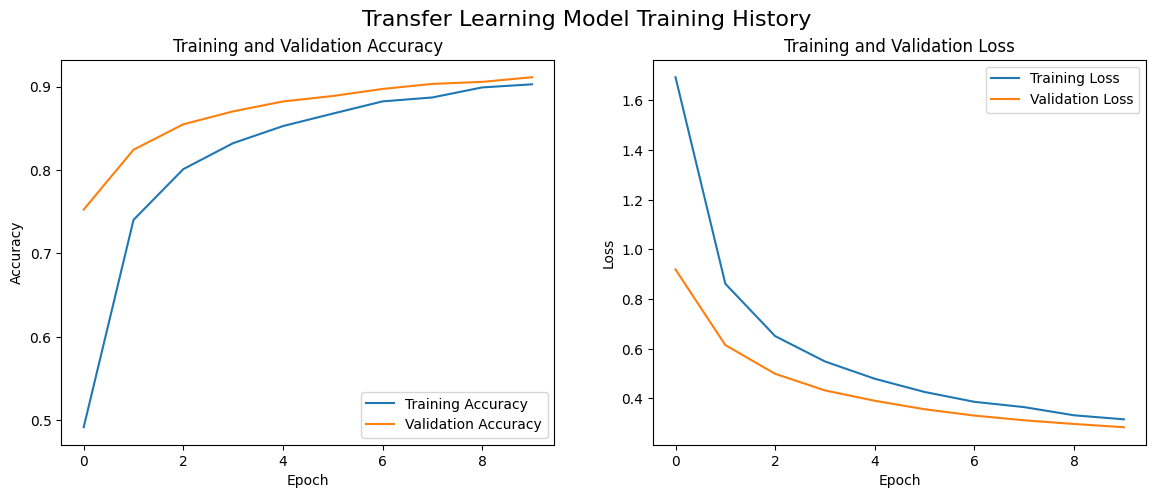


Evaluating the final model on the validation dataset...
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9089 - loss: 0.2910
--------------------------------------------------
Final Validation Loss: 0.2841
Final Validation Accuracy: 0.9113 (91.13%)
--------------------------------------------------


In [6]:
import matplotlib.pyplot as plt

# --- 1. Visualize Training History ---

# The 'history' object contains the performance metrics recorded during training.
# We will plot these to understand how the model learned over time.

print("Visualizing the transfer learning model's performance...")

# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs the model was trained for
epochs_range = range(len(acc))

# Create a figure to hold our plots
plt.figure(figsize=(14, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plots
plt.suptitle('Transfer Learning Model Training History', fontsize=16)
plt.show()


# --- 2. Evaluate the Model on the Validation Dataset ---

# Let's get the final, precise measure of the model's performance on the unseen validation data.
print("\nEvaluating the final model on the validation dataset...")

results = model.evaluate(validation_dataset)

# Print the results in a clear format
print("-" * 50)
print(f"Final Validation Loss: {results[0]:.4f}")
print(f"Final Validation Accuracy: {results[1]:.4f} ({(results[1] * 100):.2f}%)")
print("-" * 50)


Saving the trained model to: plant_disease_model.keras
Model saved successfully!

Loading the model from disk...
Model loaded successfully!

Taking a sample image from the validation set to make a prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Displaying the prediction results...


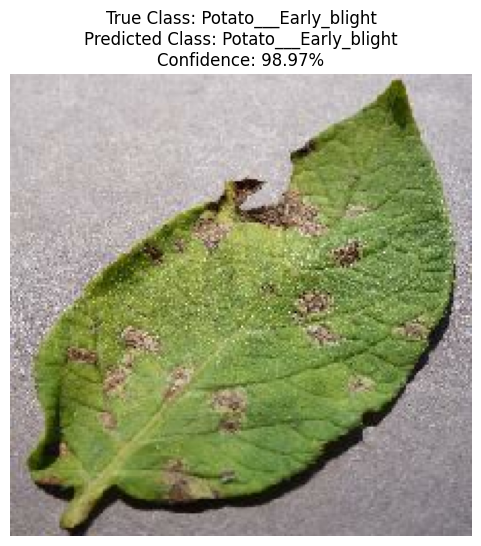

--------------------------------------------------
Prediction for a sample image:
   - True Label:      Potato___Early_blight
   - Predicted Label: Potato___Early_blight
   - Confidence:      98.97%
--------------------------------------------------


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# --- 1. Save the Trained Model ---

# It's crucial to save your trained model for future use. This saves all the learned
# weights and the model's architecture. We'll save it in the recommended .keras format.
model_save_path = 'plant_disease_model.keras'
print(f"Saving the trained model to: {model_save_path}")

# Use the model's save() method
model.save(model_save_path)

print("Model saved successfully!")


# --- 2. Load the Model (with custom objects) ---

# To show how to use the saved file, we'll now load it back.
# In a real application, you would start from this step.
# **FIX:** We must tell Keras how to handle the custom 'preprocess_input' function.
print("\nLoading the model from disk...")
loaded_model = tf.keras.models.load_model(
    model_save_path,
    custom_objects={'preprocess_input': preprocess_input}
)
print("Model loaded successfully!")


# --- 3. Prepare an Image and Make a Prediction ---

# We need the class names from the training step to interpret the model's output.
# If you don't have this variable, you'll need to re-run the part of the
# previous script that defines `class_names`.
# For convenience, let's assume they are available here.
# class_names = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', ...]


# Take one batch of images and labels from the validation dataset to test on.
print("\nTaking a sample image from the validation set to make a prediction...")
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
first_image = image_batch[0]
first_label = label_batch[0]

# Preprocess the image for prediction:
# The model expects a "batch" of images, so we add an extra dimension.
image_for_prediction = np.expand_dims(first_image, axis=0)

# Make the prediction
prediction = loaded_model.predict(image_for_prediction)
predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(prediction) * 100

# Get the true class name for comparison
true_class_index = np.argmax(first_label)
true_class_name = class_names[true_class_index]


# --- 4. Display the Result ---

print("Displaying the prediction results...")
plt.figure(figsize=(6, 6))
plt.imshow(first_image.astype("uint8"))
plt.title(f"True Class: {true_class_name}\n"
            f"Predicted Class: {predicted_class_name}\n"
            f"Confidence: {confidence:.2f}%")
plt.axis("off")
plt.show()

# Print a summary to the console
print("-" * 50)
print(f"Prediction for a sample image:")
print(f"   - True Label:      {true_class_name}")
print(f"   - Predicted Label: {predicted_class_name}")
print(f"   - Confidence:      {confidence:.2f}%")
print("-" * 50)



Build by Immani Rama Venkata Sri Sai



